In [111]:
library(ggplot2)  # Plotting
library(gridExtra)  # Grid plotting
library(geosphere) # Spatial coordinates
library(caret) # Prediction
library(Metrics)  # Error measurement

library("GGally", lib.loc="/Library/Frameworks/R.framework/Versions/3.5/Resources/library")


Attaching package: ‘Metrics’

The following objects are masked from ‘package:caret’:

    precision, recall



In [2]:
train_dataset_raw = read.csv("data/train.csv")

In [123]:
# We reduce the dataframe size to be more workable

N = 1000
train_dataset = train_dataset_raw[sample(nrow(train_dataset_raw), N), ]

## 1. Filter the data

In [124]:
# Filter some absurd values:

# Trips too long
MAX_TRIP_DURATION = 2 * 3600
MIN_TRIP_DURATION = 30
train_dataset = train_dataset[
    train_dataset$trip_duration < MAX_TRIP_DURATION &
    train_dataset$trip_duration > MIN_TRIP_DURATION,
]

## 2. Create some features

In [135]:
# distHaversine

train_dataset$distHaversine = numeric(length(train_dataset$dropoff_latitude))
for (i in 1:length(train_dataset$dropoff_latitude)) {
    train_dataset$distHaversine[i] = distm(
        c(train_dataset$pickup_longitude[i], train_dataset$pickup_latitude[i]),
        c(train_dataset$dropoff_longitude[i], train_dataset$dropoff_latitude[i]),
        fun = distHaversine
    )
}

# log_trip duration

train_dataset$log_trip_duration = log(train_dataset$trip_duration)

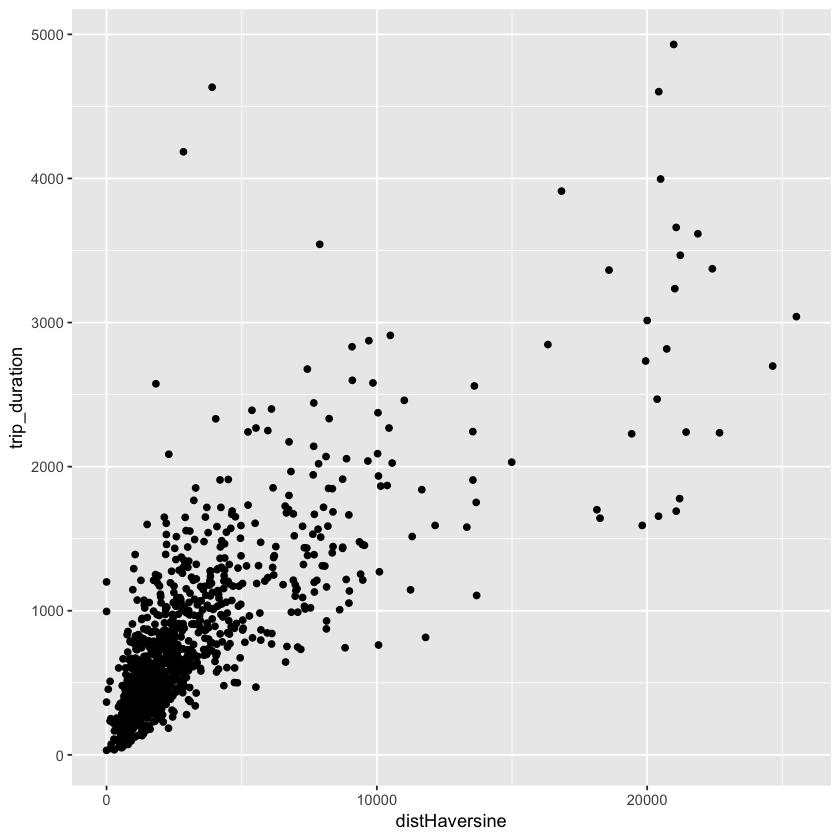

In [126]:
ggplot() + 
  geom_point(data = train_dataset, 
             aes(x = distHaversine, y = trip_duration))

#### Date et Heure

In [ ]:
train_dataset$pickup_month <- month(train_dataset$pickup_datetime)
train_dataset$pickup_hour <- hour(train_dataset$pickup_datetime)

In [ ]:
#ajout de l'heure de départ en secondes
x=as.character(train_dataset$pickup_datetime);
dtparts = t(as.data.frame(strsplit(x,' ')));
train_dataset$pickup_hour_in_seconds=as.numeric(as.duration(hms(dtparts[,2])))

In [ ]:
#Création d'une colonne pour les jours de la semaine
y=as.Date(train$pickup_datetime);
train_dataset$pickup_day=format(y, "%A")

## Prediction modeling

In [137]:
set.seed(998)
inTraining <- createDataPartition(train_dataset$trip_duration, p = .75, list = FALSE)
training <- train_dataset[ inTraining,]
testing  <- train_dataset[-inTraining,]

In [128]:
fitControl <- trainControl(## 10-fold CV
                           method = "repeatedcv",
                           number = 2,
                           ## repeated ten times
                           repeats = 2)

In [129]:
earth_predictor <- train(trip_duration ~ distHaversine, data = training, 
                 method = "earth"
                )

In [130]:
testing$prediction = predict(earth_predictor, testing)
testing$error = abs(testing$trip_duration - testing$prediction)

gbmFit1

Multivariate Adaptive Regression Spline 

76 samples
 1 predictor

No pre-processing
Resampling: Bootstrapped (25 reps) 
Summary of sample sizes: 76, 76, 76, 76, 76, 76, ... 
Resampling results across tuning parameters:

  nprune  RMSE      Rsquared   MAE     
  2       778.7368  0.4636976  410.1444
  3       650.9047  0.6720712  319.1000
  5       653.3585  0.6717722  320.7685

Tuning parameter 'degree' was held constant at a value of 1
RMSE was used to select the optimal model using the smallest value.
The final values used for the model were nprune = 3 and degree = 1.

In [115]:
rmsle(testing$trip_duration, testing$error)

[1] 1.939842

In [133]:
fitControl <- trainControl(## 10-fold CV
                           method = "repeatedcv",
                           number = 2,
                           ## repeated ten times
                           repeats = 2,
)
xgbLinear_predictor <- train(trip_duration ~ distHaversine + pickup_longitude + pickup_latitude + dropoff_longitude + dropoff_latitude , data = training, 
                 method = "xgbLinear"
                )

In [134]:
testing$prediction = predict(xgbLinear_predictor, testing)
testing$error = abs(testing$trip_duration - testing$prediction)

xgbLinear_predictor

rmsle(testing$trip_duration, testing$error)

eXtreme Gradient Boosting 

747 samples
  5 predictor

No pre-processing
Resampling: Bootstrapped (25 reps) 
Summary of sample sizes: 747, 747, 747, 747, 747, 747, ... 
Resampling results across tuning parameters:

  lambda  alpha  nrounds  RMSE      Rsquared   MAE     
  0e+00   0e+00   50      451.2267  0.5320722  296.8659
  0e+00   0e+00  100      452.2365  0.5307044  298.0345
  0e+00   0e+00  150      452.3765  0.5305273  298.1847
  0e+00   1e-04   50      451.2266  0.5320722  296.8659
  0e+00   1e-04  100      452.2032  0.5307338  298.0327
  0e+00   1e-04  150      452.3312  0.5305634  298.1683
  0e+00   1e-01   50      451.3459  0.5316088  297.2384
  0e+00   1e-01  100      452.5354  0.5300642  298.5491
  0e+00   1e-01  150      452.6653  0.5299060  298.6691
  1e-04   0e+00   50      451.4913  0.5315324  296.8014
  1e-04   0e+00  100      452.3815  0.5304278  298.0265
  1e-04   0e+00  150      452.4665  0.5303036  298.1339
  1e-04   1e-04   50      451.4913  0.5315324  296.8014
 

[1] 1.836831

### Here we try with the log of the trip_duration

In [138]:
fitControl <- trainControl(## 10-fold CV
                           method = "repeatedcv",
                           number = 2,
                           ## repeated ten times
                           repeats = 2,
)
xgbLinear_predictor <- train(log_trip_duration ~ distHaversine + pickup_longitude + pickup_latitude + dropoff_longitude + dropoff_latitude , data = training, 
                 method = "xgbLinear"
                )
testing$prediction = predict(xgbLinear_predictor, testing)
testing$error = abs(testing$log_trip_duration - testing$prediction)

xgbLinear_predictor



eXtreme Gradient Boosting 

747 samples
  5 predictor

No pre-processing
Resampling: Bootstrapped (25 reps) 
Summary of sample sizes: 747, 747, 747, 747, 747, 747, ... 
Resampling results across tuning parameters:

  lambda  alpha  nrounds  RMSE       Rsquared   MAE      
  0e+00   0e+00   50      0.5066993  0.5429062  0.3865567
  0e+00   0e+00  100      0.5084566  0.5406506  0.3880234
  0e+00   0e+00  150      0.5086983  0.5403393  0.3882290
  0e+00   1e-04   50      0.5071212  0.5421257  0.3865666
  0e+00   1e-04  100      0.5091420  0.5394565  0.3884212
  0e+00   1e-04  150      0.5093684  0.5391555  0.3886401
  0e+00   1e-01   50      0.5021277  0.5505189  0.3810175
  0e+00   1e-01  100      0.5041168  0.5480770  0.3825638
  0e+00   1e-01  150      0.5041412  0.5480536  0.3825817
  1e-04   0e+00   50      0.5054963  0.5443707  0.3855320
  1e-04   0e+00  100      0.5074458  0.5417921  0.3871490
  1e-04   0e+00  150      0.5076769  0.5414960  0.3873818
  1e-04   1e-04   50      0.505

[1] 6.17884

In [140]:
xgbLinear_predictor_imp <- varImp(xgbLinear_predictor, scale = FALSE)
xgbLinear_predictor_imp



xgbLinear variable importance

                  Overall
distHaversine     0.77379
pickup_longitude  0.06880
dropoff_latitude  0.06187
dropoff_longitude 0.04902
pickup_latitude   0.04652